In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv("datasets/Online Retail.csv")

In [3]:
display(data)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [4]:
data=data[["InvoiceNo","StockCode","Quantity","InvoiceDate","UnitPrice","CustomerID"]].dropna()
data["CustomerID"]=data["CustomerID"].apply(int)
data.insert(5, "Total", data["Quantity"]*data["UnitPrice"], True)
data=data[data["Quantity"]>=0]

In [5]:

customers=data["CustomerID"].unique()

    

In [6]:
import os
if not os.path.exists('output'):
    os.makedirs('output')

In [7]:
totals={"CustomerID":[],"monetary_vars":[]}
for c in customers:
    customer=data[data["CustomerID"]==c]
    total=customer["Total"].sum()
    totals["CustomerID"].append(c)
    totals["monetary_vars"].append(total)

totals=pd.DataFrame(totals)
f=open(f'output/monetary_vars.csv', "w")
totals.to_csv(path_or_buf=f,index=False,line_terminator='\n')
f.close()

In [8]:
num_invoices={"CustomerID":[],"frequency":[]}

for c in customers:
    customer=data[data["CustomerID"]==c]
    num=len(customer["InvoiceNo"].unique())
    num_invoices["CustomerID"].append(c)
    num_invoices["frequency"].append(num)
num_invoices=pd.DataFrame(num_invoices)
f=open(f'output/frequency.csv', "w")
num_invoices.to_csv(path_or_buf=f,index=False,line_terminator='\n')
f.close()


In [9]:
# recency
from datetime import datetime
from datetime import timedelta

unique_dates={"CustomerID":[],"recency":[]}
dates=list(data["InvoiceDate"].unique())
dates.sort(key = lambda date: datetime.strptime(date, '%m/%d/%Y %H:%M'))
date_time_obj = datetime.strptime(dates[len(dates)-1], '%m/%d/%Y %H:%M')
# now=datetime.now()
now=date_time_obj+ timedelta(days=1)
for c in customers:
    customer=data[data["CustomerID"]==c]
    dates=list(customer["InvoiceDate"].unique())
    dates.sort(key = lambda date: datetime.strptime(date, '%m/%d/%Y %H:%M'))
    date_time_obj = datetime.strptime(dates[len(dates)-1], '%m/%d/%Y %H:%M')

    unique_dates["CustomerID"].append(c)
    unique_dates["recency"].append((now-date_time_obj).days)

unique_dates=pd.DataFrame(unique_dates)
f=open(f'output/recency.csv', "w")
unique_dates.to_csv(path_or_buf=f,index=False,line_terminator='\n')
f.close()


In [10]:
frequency = pd.read_csv("output/frequency.csv")
monetary_vars = pd.read_csv("output/monetary_vars.csv")
recency = pd.read_csv("output/recency.csv")
rfm_values=pd.DataFrame(data={"CustomerID":frequency["CustomerID"],"recency":recency["recency"],'frequency':frequency['frequency'],"monetary":monetary_vars['monetary_vars']})
rfm_values.head()

,CustomerID,recency,frequency,monetary
0,17850,372,34,5391.21
1,13047,32,10,3237.54
2,12583,3,15,7281.38
3,13748,96,5,948.25
4,15100,334,3,876.00


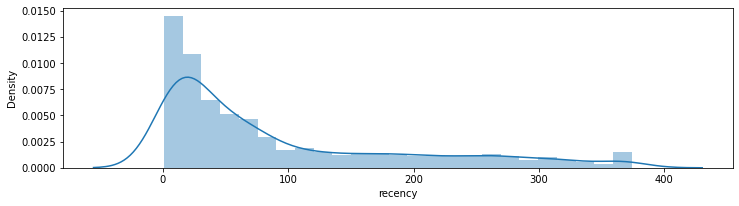

In [11]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm_values['recency'])
plt.show()


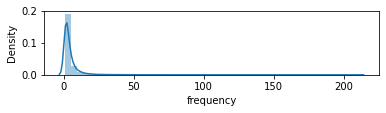

In [12]:
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm_values['frequency'])
plt.show()


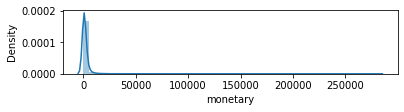

In [13]:
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm_values['monetary'])
# Show the plot
plt.show()

In [14]:
quartiles = rfm_values.quantile(q=[0.25,0.50,0.75])
quartiles

,CustomerID,recency,frequency,monetary
0.25,13812.5,18.0,1.0,307.245
0.50,15299.0,51.0,2.0,674.450
0.75,16778.5,142.0,5.0,1661.640


In [15]:
quartiles=quartiles.to_dict()
quartiles

{'CustomerID': {0.25: 13812.5, 0.5: 15299.0, 0.75: 16778.5},
 'recency': {0.25: 18.0, 0.5: 51.0, 0.75: 142.0},
 'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'monetary': {0.25: 307.24499999999995,
  0.5: 674.4499999999998,
  0.75: 1661.6399999999999}}

Creating the RFM segmentation table

the two methods create two classes for the RFM segmentation since, being high recency is bad, while high frequency and monetary value is good.




In [16]:
rfmSegmentation = rfm_values
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1


In [17]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quartiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary'].apply(FMClass, args=('monetary',quartiles,))

In [18]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [19]:
rfmSegmentation.head()

,CustomerID,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,17850,372,34,5391.21,4,1,1,411
1,13047,32,10,3237.54,2,1,1,211
2,12583,3,15,7281.38,1,1,1,111
3,13748,96,5,948.25,3,2,2,322
4,15100,334,3,876.00,4,2,2,422


Top ten customers 

In [20]:
rfmSegmentation[rfmSegmentation['RFMClass']=='111'].head(10)

,CustomerID,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMClass
2,12583,3,15,7281.38,1,1,1,111
6,14688,8,21,5630.87,1,1,1,111
7,17809,16,12,5411.91,1,1,1,111
8,15311,1,91,60767.90,1,1,1,111
15,17511,3,31,91062.38,1,1,1,111
18,13408,2,62,28117.04,1,1,1,111
19,13767,2,37,17220.36,1,1,1,111
20,17924,12,7,2962.50,1,1,1,111
21,13448,17,6,3539.37,1,1,1,111
29,17920,4,17,4204.10,1,1,1,111


RFM Class (111), high spenders who buy recently and frequently?

In [21]:
display(rfmSegmentation[rfmSegmentation['RFMClass']=='111'])

,CustomerID,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMClass
2,12583,3,15,7281.38,1,1,1,111
6,14688,8,21,5630.87,1,1,1,111
7,17809,16,12,5411.91,1,1,1,111
8,15311,1,91,60767.90,1,1,1,111
15,17511,3,31,91062.38,1,1,1,111
...,...,...,...,...,...,...,...,...
3724,15473,14,7,1771.20,1,1,1,111
3732,13685,3,7,3119.44,1,1,1,111
3791,14547,4,8,4007.54,1,1,1,111
3920,15993,9,7,2797.57,1,1,1,111


In [22]:
rfmSegmentation.head(10)

,CustomerID,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,17850,372,34,5391.21,4,1,1,411
1,13047,32,10,3237.54,2,1,1,211
2,12583,3,15,7281.38,1,1,1,111
3,13748,96,5,948.25,3,2,2,322
4,15100,334,3,876.00,4,2,2,422
5,15291,26,15,4668.30,2,1,1,211
6,14688,8,21,5630.87,1,1,1,111
7,17809,16,12,5411.91,1,1,1,111
8,15311,1,91,60767.90,1,1,1,111
9,16098,88,7,2005.63,3,1,1,311


In [23]:
f=open(f'output/rfm.csv', "w")
rfmSegmentation.to_csv(path_or_buf=f,index=False,line_terminator='\n')
f.close()